# Experiments for Vehicle Detection and Tracking

This notebook is baiscally an exploratory workbook to play with the data and visualize it. The final computations are moved into two python scripts called `train_clf.py` to train the classifier and `detect_and_track.py` to annotate the video

## Read Data

In [1]:
from helper.io import read_data_set
from helper.feature_extrection import data_look
vehicle_files, non_vehicle_files = read_data_set("./data")
print(data_look(vehicle_files, non_vehicle_files))

{'n_notcars': 8968, 'image_shape': (64, 64, 3), 'n_cars': 8792, 'data_type': dtype('float32')}


## Feature Extraction
now we have the paths to the dataset we must extract the features for each instance to get a vecture vector, and stack that in a veature matrix and a target vector

In [2]:
from helper.feature_extrection import extract_features

vehicle_features = extract_features(vehicle_files, cspace="HLS", use_spacial=False, hist_range=(0,1), cell_per_block=1)
non_vehicle_features = extract_features(non_vehicle_files, cspace="HLS", use_spacial=False, hist_range=(0,1), cell_per_block=1)

('convert img to color: ', 'HLS')
('num hist features: ', 96)
('hist describe: ', DescribeResult(nobs=96, minmax=(0.0, 0.248046875), mean=0.0625, variance=0.006345407586348684, skewness=0.9900791087517596, kurtosis=-0.5097607069851007))
('num hog features: ', 432)
('hog describe: ', DescribeResult(nobs=432, minmax=(0.0, 0.79858726665658175), mean=0.11099490810662109, variance=0.016294291464609454, skewness=2.66464872416733, kurtosis=8.883622552322668))
('convert img to color: ', 'HLS')
('num hist features: ', 96)
('hist describe: ', DescribeResult(nobs=96, minmax=(0.0, 1.31640625), mean=0.0625, variance=0.045653493780838814, skewness=4.688724299522603, kurtosis=22.08974318055931))
('num hog features: ', 432)
('hog describe: ', DescribeResult(nobs=432, minmax=(0.0, 0.59652856652042885), mean=0.10416167021466827, variance=0.0070605303004962119, skewness=1.8938332726413722, kurtosis=5.078619296453567))


In [6]:
print("vehicle_features shape:", vehicle_features[0].shape)

vehicle_features shape: (528,)


In [9]:
import numpy as np
from helper.classification import scale_features
X = np.vstack((vehicle_features + non_vehicle_features)).astype(np.float64)
scaled_X, X_scaler = scale_features(X)

y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

## Fit Model and test
now we have the features and the target vector, we can finally train our model. We split the sample into a 20% train, test split

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
svc = LinearSVC()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9778


In [19]:
# save the model to disk:
import pickle
with open('svc.p', 'wb') as f:
    pickle.dump(svc, f)
with open('scaler.p', 'wb') as f:
    pickle.dump(X_scaler, f)

# Sliding Window & Pipeline Experiments
This Notebook is basically a set of experiments for the real detection pipeline. Concretely it uses some test images to experiment and visualize with the sliding window computation strategy, and experiments for finding a suteable threshold for the headmap.

## Find slidning windows
We define sliding windows to search for cars. To not blow the computations we try to minimise the effort, but still have a good detection rate. Therefor we limit the search area to approx. the lower half of the image. Also do be less resolution dependent different sized sliding windows are used who then are all down or upsampled to the same size.

In [27]:
import matplotlib.image as mpimg
from helper.sliding_window import slide_window
image = mpimg.imread('test_images/test1.jpg')

layer1 = slide_window(image, y_start_stop=[380, None], xy_window=(192,192))
layer2 = slide_window(image, y_start_stop=[380, 650], xy_window=(128,128))
layer3 = slide_window(image, y_start_stop=[380, 650], xy_window=(96, 96))
layer4 = slide_window(image, y_start_stop=[380, 600], xy_window=(64,64))
all_layers = layer1 + layer2 + layer3 + layer4

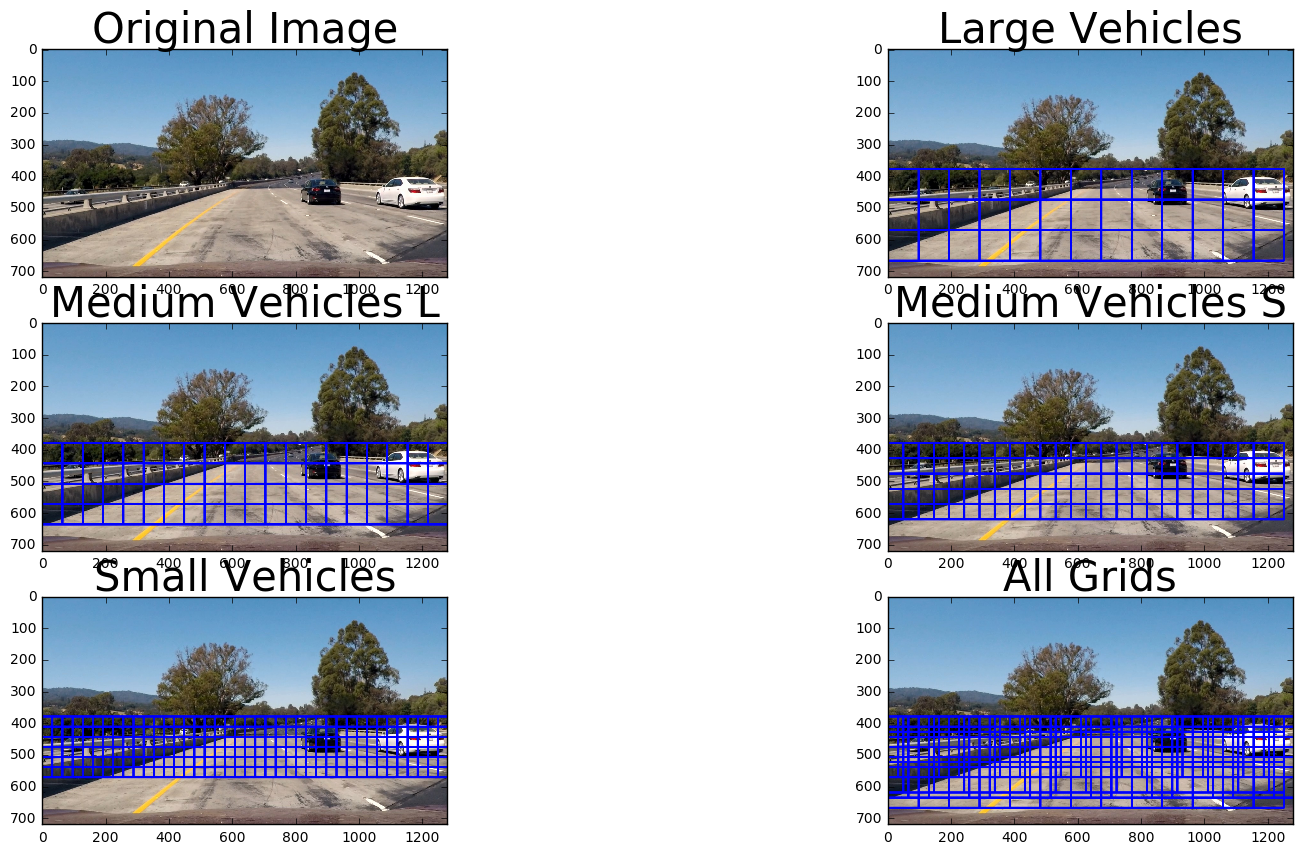

In [28]:
import matplotlib.pyplot as plt
from helper.draw import draw_boxes
%matplotlib inline

f, axarr = plt.subplots(3, 2, figsize=(20,10))

axarr[0, 0].imshow(image)
axarr[0, 0].set_title('Original Image', fontsize=30)

l1img = draw_boxes(image, layer1)
axarr[0, 1].imshow(l1img)
axarr[0, 1].set_title('Large Vehicles', fontsize=30)

l2img = draw_boxes(image, layer2)
axarr[1, 0].imshow(l2img)
axarr[1, 0].set_title('Medium Vehicles L', fontsize=30)

l3img = draw_boxes(image, layer3)
axarr[1, 1].imshow(l3img)
axarr[1, 1].set_title('Medium Vehicles S', fontsize=30)

l4img = draw_boxes(image, layer4)
axarr[2, 0].imshow(l4img)
axarr[2, 0].set_title('Small Vehicles', fontsize=30)

lall_img = draw_boxes(image, all_layers)
axarr[2, 1].imshow(lall_img)
axarr[2, 1].set_title('All Grids', fontsize=30)

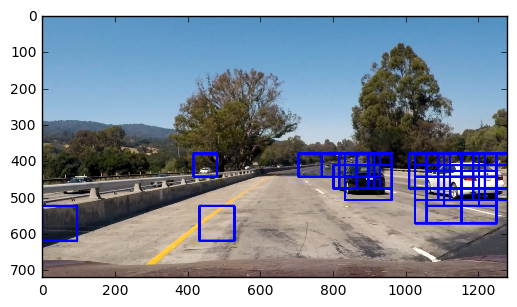

In [29]:
from helper.sliding_window import search_windows

found = search_windows(image, all_layers, svc, X_scaler, color_space="HLS", spatial_feat=False, hist_range=(0,256), cell_per_block=1)
test_img = draw_boxes(image, found)
plt.imshow(test_img)